In [1]:
from common import *
from experiment import *
from heuristic import *
from data import DirectRawData, RawData, PlottableData
from typing import List, Tuple, Optional, Union, Dict

# Generate initial network setting combinations

## Helper functions

In [2]:
def get_splits(
    sorted_values: List[any],
    combine_func,
) -> List[Tuple[any, any]]:
    """
    Help determine which split network settings combine to make an e2e network setting within
    one dimension of the network model.

    Parameters:
    - sorted_values: List of values e.g. delays available in the parameter exploration space,
      in sorted order
    - combine_func: The function that takes as input the values of two network path segments,
      and returns the value of the combined end-to-end network path.

    Returns:
    - The split values on two network path segments which, when combined, both the split and
      combined values are available in the parameter exploration space.
    """
    splits = set()
    max_value = sorted_values[-1]
    for value_i in sorted_values:
        for value_j in sorted_values:
            combined_value = combine_func(value_i, value_j)
            if combined_value <= max_value:
                splits.add((value_i, value_j))
    return list(sorted(list(splits)))

In [3]:
def get_network_settings(
    losses: List[Union[int, float, str]],
    delays: List[int],
    bws: List[int],
) -> List[Tuple[NetworkModel, NetworkModel]]:
    """
    Get all plausible network setting combinations from the parameter exploration space.

    Parameters:
    - losses: Loss values in the parameter exploration space.
    - delays: Delay values in the parameter exploration space.
    - bws: Bandwidth values in the parameter exploration space.
    
    Returns:
    - Pairs of network path segments which, when combined, are also in the cached data.
    """
    loss_splits = get_splits(losses, combine_loss)
    delay_splits = get_splits(delays, combine_delay)
    bw_splits = get_splits(bws, combine_bw)
    # Note: Assume the same bandwidth on each path segment as it is actually more important
    # what the sending rate is rather than the max capacity.
    # bw_splits = [(bw, bw) for bw in bws]
    
    nses = []
    for bw1, bw2 in bw_splits:
        for loss1, loss2 in loss_splits:
            for delay1, delay2 in delay_splits:
                s1 = NetworkModel(delay1, loss1, bw1)
                s2 = NetworkModel(delay2, loss2, bw2)
                nses.append((s1, s2))
    return nses

In [4]:
from enum import Enum

class SplitType(Enum):
    ASYMMETRIC_NEAR = 1
    ASYMMETRIC_FAR = 2
    ASYMMETRIC_LOSSY = 3
    SYMMETRIC_LOSSY = 4
    ZERO_LOSS = 5
    OTHER = 6

class ThroughputResult:
    def __init__(self, data: Dict[str, TreatmentData], s1: NetworkModel, s2: NetworkModel):
        self.goodput = {}
        self.bottleneck_bw = min(s1.bw, s2.bw)
        self.s1 = s1
        self.s2 = s2
        for treatment in data:
            # (split, e2e)
            treatment_data = data[treatment]
            split_goodput = treatment_data.pred_split_goodput(s1, s2)
            e2e_goodput = treatment_data.pred_e2e_goodput(s1, s2)
            self.goodput[treatment] = (split_goodput, e2e_goodput)

    def treatments(self) -> List[str]:
        return list(self.goodput.keys())

    def split_goodput(self, treatment: Union[Treatment, str]) -> float:
        if isinstance(treatment, str):
            label = treatment
        else:
            label = treatment.label()
        return self.goodput[label][0]

    def e2e_goodput(self, treatment: Union[Treatment, str]) -> float:
        if isinstance(treatment, str):
            label = treatment
        else:
            label = treatment.label()
        return self.goodput[label][1]

    def split_ratio(self, treatment: Union[Treatment, str]) -> float:
        return self.split_goodput(treatment) / self.bottleneck_bw

    def e2e_ratio(self, treatment: Union[Treatment, str]) -> float:
        return self.e2e_goodput(treatment) / self.bottleneck_bw

    def split_improvement_mul(self, treatment: Union[Treatment, str]) -> float:
        split_goodput = self.split_goodput(treatment)
        e2e_goodput = self.e2e_goodput(treatment)
        if not e2e_goodput:
            return float('inf')
        else:
            return (split_goodput - e2e_goodput) / e2e_goodput

    def split_improvement_add(self, treatment: Union[Treatment, str]) -> float:
        split_goodput = self.split_goodput(treatment)
        e2e_goodput = self.e2e_goodput(treatment)
        return split_goodput - e2e_goodput

    def split_type(self) -> SplitType:
        s1 = self.s1  # far path segment
        s2 = self.s2  # near path segment
        if s2.delay == 1 and s2.loss > 0 and s1.delay > 1 and s1.loss == 0:
            return SplitType.ASYMMETRIC_NEAR
        elif s1.delay == 1 and s1.loss > 0 and s2.delay > 1 and s2.loss == 0:
            return SplitType.ASYMMETRIC_FAR
        elif s1.loss > 0 and s2.loss > 0:
            if s1.delay == 1 or s2.delay == 1:
                return SplitType.ASYMMETRIC_LOSSY
            else:
                return SplitType.SYMMETRIC_LOSSY
        elif s1.loss == 0 and s2.loss == 0:
            return SplitType.ZERO_LOSS
        else:
            return SplitType.OTHER

    def __repr__(self) -> str:
        s1 = self.s1
        s2 = self.s2
        return f'{s1.delay}ms {s1.loss}% {s1.bw}Mbit/s, {s2.delay}ms {s2.loss}% {s2.bw}Mbit/s'

In [5]:
def get_initial_results(
    data: Dict[str, TreatmentData],
    network_settings: List[Tuple[NetworkModel, NetworkModel]],
) -> List[ThroughputResult]:
    results = []
    for s1, s2 in network_settings:
        result = ThroughputResult(data, s1, s2)
        results.append(result)
    return results

## Generate network settings

In [6]:
#15
#21
#25
LOSSES = [0, 1, 2, 3, 4]
DELAYS = [1, 20, 40, 60, 80, 100]
BWS = [10, 20, 30, 40, 50]

In [7]:
# Generate all network settings
network_settings = get_network_settings(LOSSES, DELAYS, BWS)

# Helper functions to analyze network settings

In [8]:
def filter_by(results, func, note=''):
    results = list(filter(func, results))
    print(len(results), note)
    return results

In [9]:
def show_random_results(results, n=3):
    """Randomly plot n results.
    """
    if len(results) < n:
        indexes = range(len(results))
    else:
        import random
        indexes = random.sample(range(len(results)), n)
    for i in indexes:
        plot_predicted_data(results[i])
    print('...')

# Helper functions to visualize network settings

In [10]:
# Function that plots what the predicted data looks like
groups = ['CUBIC\n(2006)', 'BBRv1\n(2016)', 'BBRv2\n(2019)', 'BBRv3\n(2023)']

def plot_predicted_data(result: ThroughputResult, ylabel='Link Rate Utilization', title=False):    
    # Setup calculations
    network = data.network_settings[0]
    ns = data.exp.get_network_setting(network)
    bottleneck_bw = min(ns.get('bw1'), ns.get('bw2'))

    # Bar width and positions
    bar_width = 0.35
    x = np.arange(len(groups))  # group positions
    
    # Create the plot
    fig, ax = plt.subplots()
    
    # Add bars for each treatment
    split_values = [result.split_goodput(treatment) for treatment in groups]
    ax.bar(x - bar_width/2, split_values, bar_width, label='Split')
    if 'utilization' in ylabel.lower():
        e2e_values = [result.e2e_goodput(cca) / bottleneck_bw for cca in groups]
    else:
        e2e_values = [result.e2e_goodput(cca) for cca in groups]
    ax.bar(x + bar_width/2, e2e_values, bar_width, label='End-to-End')
        
    # Labeling and formatting
    ax.set_xlabel('TCP Congestion Control Algorithms')
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(result.__repr__())
    else:
        print(result.__repr__())
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.grid()
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Workspace to filter interesting network settings for BBR over time

In [11]:
# All data should be generated in parameter_exploration.ipynb. This cell only parses the data.
treatments = [TCP_CUBIC, TCP_BBRV1, TCP_BBRV2, TCP_BBRV3]
# treatments += [QUIC_CUBIC, QUIC_BBRV1, QUIC_BBRV3]
# treatments += [QUICHE_CUBIC, QUICHE_BBRV1, QUICHE_BBRV2]
direct_data = gen_direct_data(losses=LOSSES, delays=DELAYS, bws=BWS, treatments=treatments, num_trials=20)

# Partition data
data = {treatment.label(): TreatmentData(treatment, direct_data) for treatment in treatments}

## Analyze classes of network paths for each CCA

### CUBIC

All network types for which CUBIC has a large improvement in split performance over e2e performance, and in which e2e performance achieves a good ratio of the bottleneck bandwidth, fall into the ASYMMETRIC_NEAR or ASYMMETRIC_FAR categories.

7875 
2231 split performance is at least 3x better than e2e performance
942 split performance achieves good ratio of botttleneck bw
471 asymmetric split type with the bottleneck on the near path segment


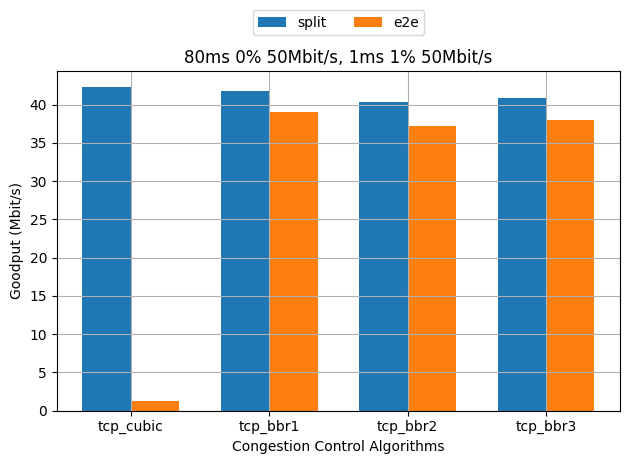

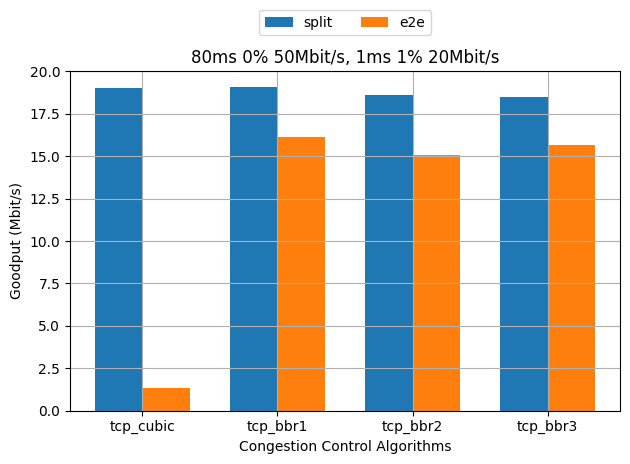

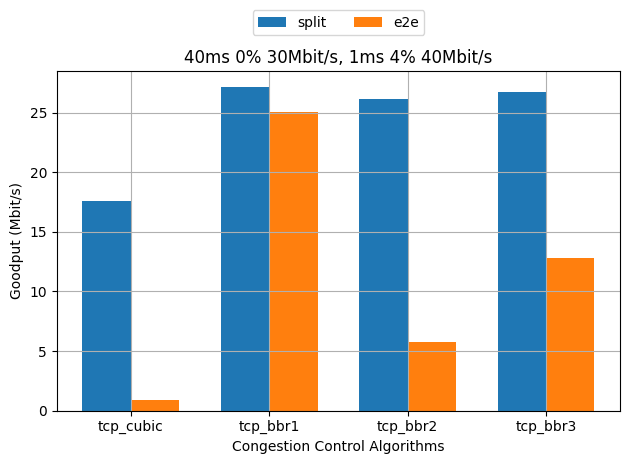

...


In [12]:
treatment = TCP_CUBIC

# Get initial results
results = get_initial_results(data, network_settings)

# Filter by required result trend criteria
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_improvement_mul(treatment) > 2, 'split performance is at least 3x better than e2e performance')
results = filter_by(results, lambda x: x.split_ratio(treatment) > 0.5, 'split performance achieves good ratio of botttleneck bw')
# results = filter_by(results, lambda x: x.e2e_goodput(treatment) > 0, 'e2e performance is nonzero')

# Filter by network split type
results = filter_by(results, lambda x: x.split_type() == SplitType.ASYMMETRIC_NEAR, 'asymmetric split type with the bottleneck on the near path segment')
# results = filter_by(results, lambda x: x.split_type() == SplitType.ASYMMETRIC_FAR, 'asymmetric split type with the bottleneck on the far path segment')

# Show results
show_random_results(results)

### BBRv1

There are no network settings where split performance is at least 2x (or even 50%) better than e2e performance for BBRv1.

In [13]:
treatment = TCP_BBRV1

# Get initial results
results = get_initial_results(data, network_settings)

# Filter by required result trend criteria
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_ratio(treatment) > 0.5, 'split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.split_improvement_mul(treatment) > 0.5, 'split performance is at least 50% better than e2e performance')

# Show results
show_random_results(results)

7875 
7875 split performance achieves good ratio of botttleneck bw
0 split performance is at least 50% better than e2e performance
...


### BBRv3

Network types for which BBRv3 has a large improvement in split performance over e2e performance, and in which e2e performance achieves a good ratio of the bottleneck bandwidth, fall into the same ASYMMETRIC_NEAR or ASYMMETRIC_FAR categories as CUBIC. BUT BBRv3 actually achieves good (at least 3x better than e2e) split goodput for many network settings in which there is loss on both path segments, including those for which the delay is more symmetric.

7875 
234 split performance is at least 3x better than e2e performance
188 split performance achieves good ratio of botttleneck bw
188 e2e performance is nonzero
38 network type is the common asymmetric kind
72 network type is the NEW kind where both path segments are lossy and pep is near the edge
78 network type is the NEW kind where both path segments are lossy and pep is far from the edge


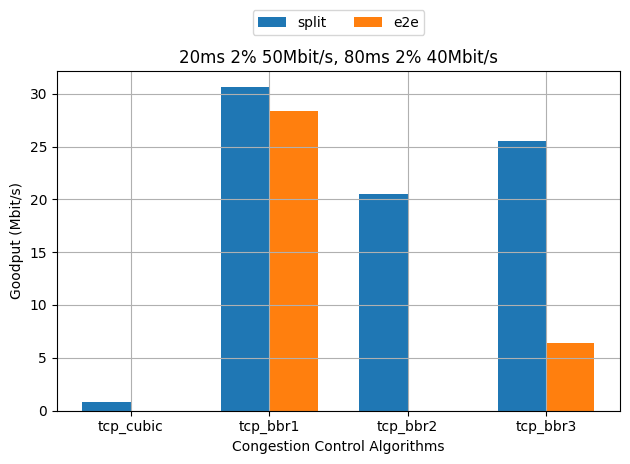

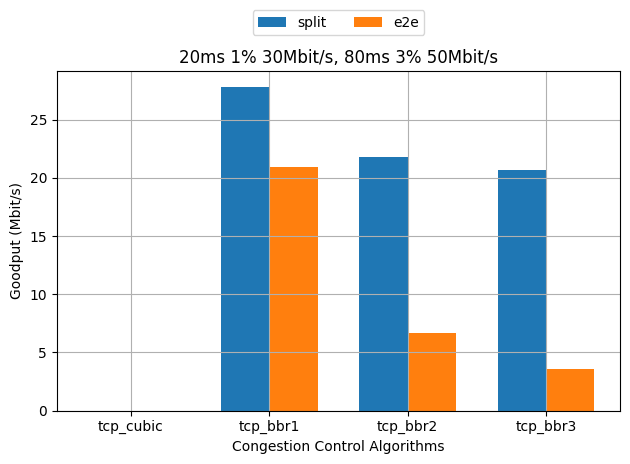

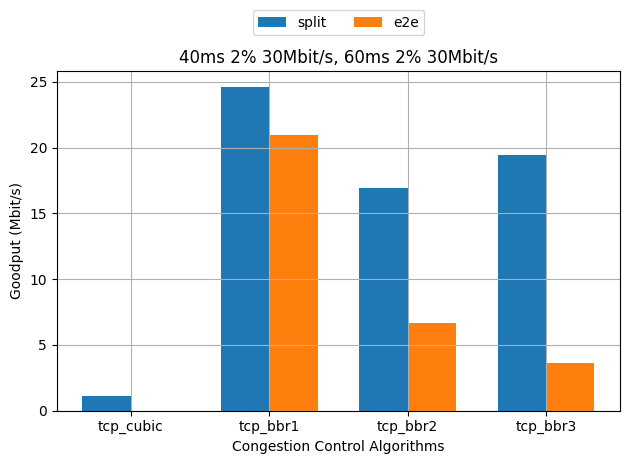

...


In [14]:
treatment = TCP_BBRV3

# Get initial results
results = get_initial_results(data, network_settings)

# Filter by required result trend criteria
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_improvement_mul(treatment) > 2, 'split performance is at least 3x better than e2e performance')
results = filter_by(results, lambda x: x.split_ratio(treatment) > 0.5, 'split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.e2e_goodput(treatment) > 0, 'e2e performance is nonzero')

# Filter by network split type
filter_by(results, lambda x: x.split_type() in [SplitType.ASYMMETRIC_NEAR, SplitType.ASYMMETRIC_FAR], 'network type is the common asymmetric kind')
filter_by(results, lambda x: x.split_type() == SplitType.ASYMMETRIC_LOSSY, 'network type is the NEW kind where both path segments are lossy and pep is near the edge')
results = filter_by(results, lambda x: x.split_type() == SplitType.SYMMETRIC_LOSSY, 'network type is the NEW kind where both path segments are lossy and pep is far from the edge')

# Show results
show_random_results(results)

## Find marquee network settings

### Asymmetric type - both CUBIC and BBRv3 benefit

7875 
500 network type is the common asymmetric kind
500 bbrv3 split performance achieves good ratio of botttleneck bw
74 bbrv3 split performance is at least 2x better than e2e performance
74 bbrv3 e2e performance is nonzero
54 cubic split performance achieves good ratio of botttleneck bw
54 cubic split performance is at least 2x better than e2e performance
21 delay1 == 100
1 bw1 == bw2 == 20


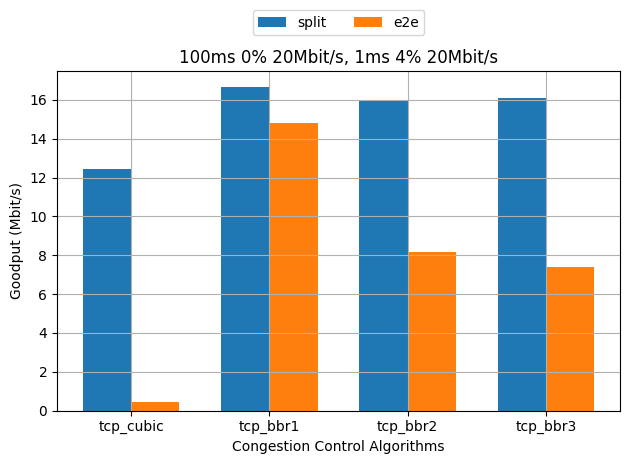

...


In [15]:
# Get initial results
results = get_initial_results(data, network_settings)

# Filter by network split type
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_type() == SplitType.ASYMMETRIC_NEAR, 'network type is the common asymmetric kind')
# results = filter_by(results, lambda x: x.split_type() == SplitType.ASYMMETRIC_FAR, 'network type is the common asymmetric kind')

# Filter by baseline split to e2e performance
# For BBRv3
results = filter_by(results, lambda x: x.split_ratio(TCP_BBRV3) > 0.5, 'bbrv3 split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.split_improvement_mul(TCP_BBRV3) > 1, 'bbrv3 split performance is at least 2x better than e2e performance')
results = filter_by(results, lambda x: x.e2e_goodput(TCP_BBRV3) > 0, 'bbrv3 e2e performance is nonzero')
# For CUBIC
results = filter_by(results, lambda x: x.split_ratio(TCP_CUBIC) > 0.5, 'cubic split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.split_improvement_mul(TCP_CUBIC) > 1, 'cubic split performance is at least 2x better than e2e performance')
# results = filter_by(results, lambda x: x.e2e_goodput(TCP_CUBIC) > 0, 'cubic e2e performance is nonzero')

# Filter remaining graphs
results = filter_by(results, lambda x: x.s1.delay == 100, 'delay1 == 100')
results = filter_by(results, lambda x: x.s1.bw == x.s2.bw == 20, 'bw1 == bw2 == 20')

# Show results
show_random_results(results, n=10)

### Both lossy type - only BBRv3 benefits

7875 
1650 network type is asymmetric and both path segments are lossy
1592 bbrv3 split performance achieves good ratio of botttleneck bw
268 bbrv3 split performance is at least 2x better than e2e performance
268 bbrv3 e2e performance is nonzero
162 cubic e2e performance is nonzero
134 bbrv3 split performance is better
17 delay1 == 100, same as 1st network setting
1 bw1 == bw2 == 20, same as 1st network setting


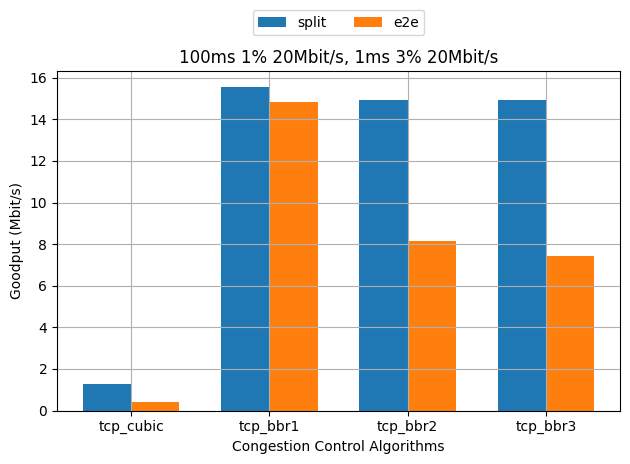

...


In [16]:
# Get initial results
results = get_initial_results(data, network_settings)

# Filter by network split type
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_type() == SplitType.ASYMMETRIC_LOSSY, 'network type is asymmetric and both path segments are lossy')

# Filter by baseline split to e2e performance
# For BBRv3
results = filter_by(results, lambda x: x.split_ratio(TCP_BBRV3) > 0.5, 'bbrv3 split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.split_improvement_mul(TCP_BBRV3) > 1, 'bbrv3 split performance is at least 2x better than e2e performance')
results = filter_by(results, lambda x: x.e2e_goodput(TCP_BBRV3) > 0, 'bbrv3 e2e performance is nonzero')
# For CUBIC
# results = filter_by(results, lambda x: x.split_ratio(TCP_CUBIC) < 0.5, 'cubic split performance achieves poor ratio of botttleneck bw')
results = filter_by(results, lambda x: x.e2e_goodput(TCP_CUBIC) > 0, 'cubic e2e performance is nonzero')

# Filter remaining graphs
results = filter_by(results, lambda x: x.split_ratio(TCP_BBRV3) > 0.7, 'bbrv3 split performance is better')
results = filter_by(results, lambda x: x.s1.delay == 100, 'delay1 == 100, same as 1st network setting')
results = filter_by(results, lambda x: x.s1.bw == x.s2.bw == 20, 'bw1 == bw2 == 20, same as 1st network setting')

# Show results
show_random_results(results)

7875 
1500 network type is asymmetric and both path segments are lossy
1386 bbrv3 split performance achieves good ratio of botttleneck bw
222 bbrv3 split performance is at least 2x better than e2e performance
222 bbrv3 e2e performance is nonzero
71 bbrv3 split performance is better
7 symmetric delays
3 symmetric losses
1 symmetric bws


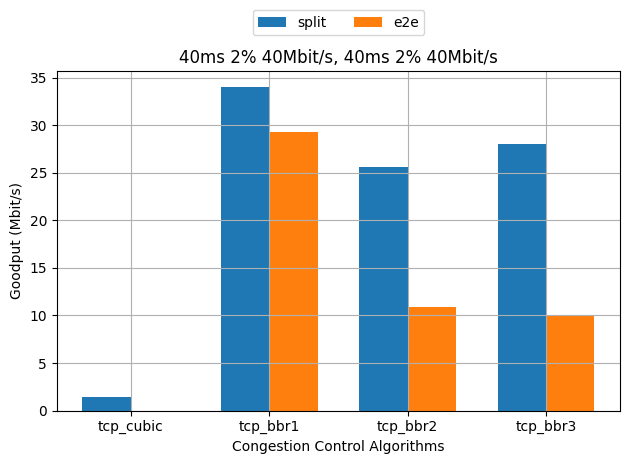

...


In [17]:
# Get initial results
results = get_initial_results(data, network_settings)

# Filter by network split type
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.split_type() == SplitType.SYMMETRIC_LOSSY, 'network type is asymmetric and both path segments are lossy')

# Filter by baseline split to e2e performance
# For BBRv3
results = filter_by(results, lambda x: x.split_ratio(TCP_BBRV3) > 0.5, 'bbrv3 split performance achieves good ratio of botttleneck bw')
results = filter_by(results, lambda x: x.split_improvement_mul(TCP_BBRV3) > 1, 'bbrv3 split performance is at least 2x better than e2e performance')
results = filter_by(results, lambda x: x.e2e_goodput(TCP_BBRV3) > 0, 'bbrv3 e2e performance is nonzero')
# For CUBIC
# results = filter_by(results, lambda x: x.split_ratio(TCP_CUBIC) < 0.5, 'cubic split performance achieves poor ratio of botttleneck bw')
# results = filter_by(results, lambda x: x.e2e_goodput(TCP_CUBIC) > 0, 'cubic e2e performance is nonzero')

# Filter remaining graphs
results = filter_by(results, lambda x: x.split_ratio(TCP_BBRV3) > 0.7, 'bbrv3 split performance is better')
results = filter_by(results, lambda x: x.s1.delay == x.s2.delay, 'symmetric delays')
results = filter_by(results, lambda x: x.s1.loss == x.s2.loss, 'symmetric losses')
results = filter_by(results, lambda x: x.s1.bw == x.s2.bw, 'symmetric bws')

# Show results
show_random_results(results)

# Summarize interesting network settings

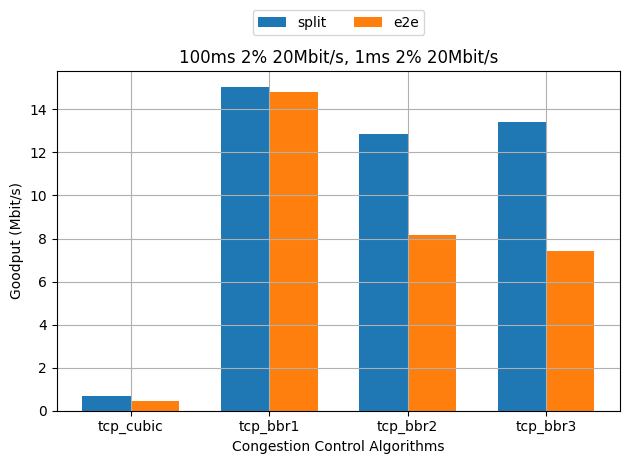

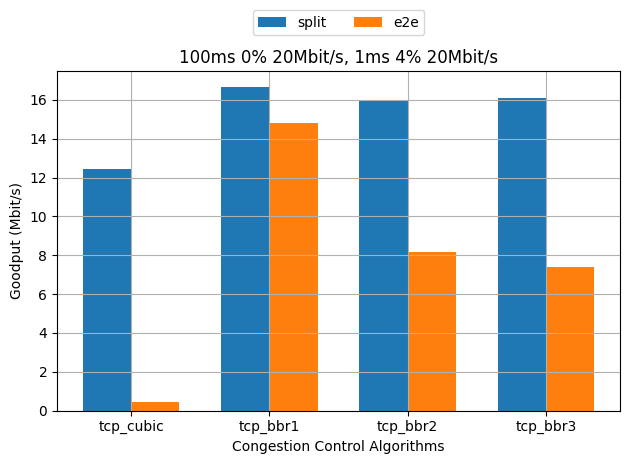

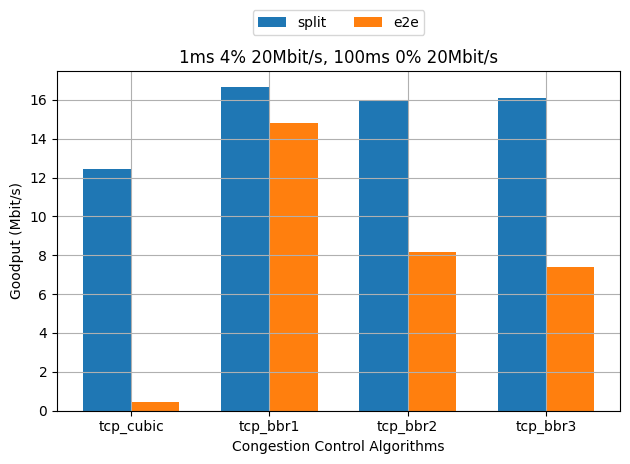

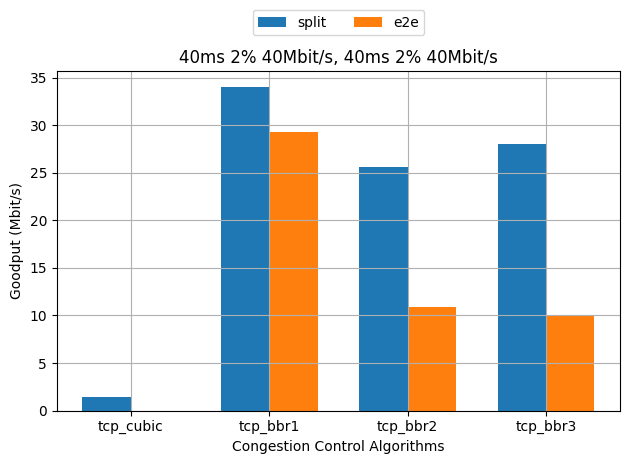

...


In [18]:
interesting_nses = [
    # delay, loss, bw
    (NetworkModel(100, 0, 20), NetworkModel(1, 4, 20)),  # ASYMMETRIC_NEAR
    (NetworkModel(1, 4, 20), NetworkModel(100, 0, 20)),  # ASYMMETRIC_FAR
    (NetworkModel(100, 2, 20), NetworkModel(1, 2, 20)),  # ASYMMETRIC_BOTH_LOSSY
    (NetworkModel(40, 2, 40), NetworkModel(40, 2, 40)),  # SYMMETRIC_BOTH_LOSSY
]

show_random_results(get_initial_results(data, interesting_nses), n=len(interesting_nses))

# Workspace to analyze QUIC results

In [19]:
# All data should be generated in parameter_exploration.ipynb. This cell only parses the data.
treatments = [TCP_CUBIC, QUIC_CUBIC, QUICHE_CUBIC, PICOQUIC_CUBIC]
treatments += [TCP_BBRV3, QUIC_BBRV3, QUICHE_BBRV2, PICOQUIC_BBRV3]
direct_data = gen_direct_data(losses=LOSSES, delays=DELAYS, bws=BWS, treatments=treatments, num_trials=20)

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --loss1 0 --topology direct -t 15 --label picoquic_cubic picoquic -cca cubic -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --topology direct -t 15 --label picoquic_cubic picoquic -cca cubic -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --delay1 20 --loss1 0 --topology direct -t 15 --label picoquic_cubic picoquic -cca cubic -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --loss1 2 --topology direct -t 15 --label picoquic_cubic picoquic -cca cubic -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --delay1 20 --topology direct -t 15 --label picoquic_cubic picoquic -cca cubic -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --delay1 40 --loss1 0 --topology direct -t 15 --label picoquic_cubic picoquic -cca cubic -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 1

## CUBIC

7875 
6248 quiche e2e performance is nonzero
5724 quiche split performance is nonzero
1639 quiche large split improvement
1255 picoquic large split improvement
1255 small e2e ratio
1237 small e2e ratio
876 small e2e ratio
448 small e2e ratio
370 small split ratio
336 small split ratio
20 large split ratio
4 large split ratio


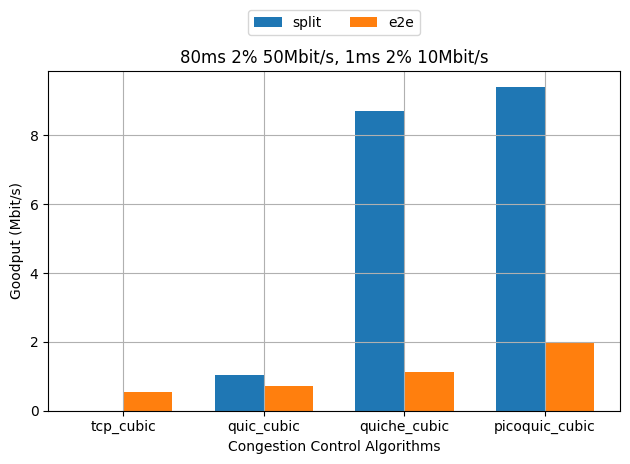

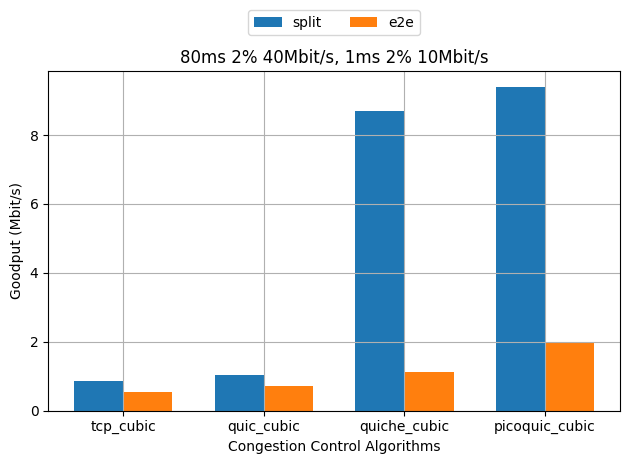

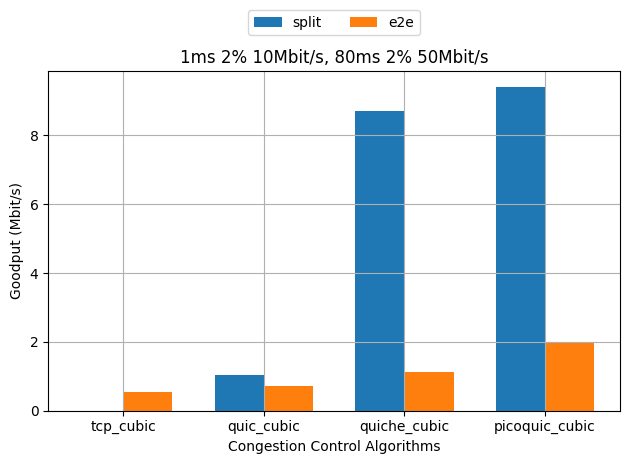

...


In [20]:
# Partition data
data = {treatment.label(): TreatmentData(treatment, direct_data) for treatment in treatments[:4]}

# Get initial results
results = get_initial_results(data, network_settings)

# Filter by required result trend criteria
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: 0 < x.e2e_ratio(QUICHE_CUBIC), 'quiche e2e performance is nonzero')
results = filter_by(results, lambda x: 0 < x.split_ratio(QUICHE_CUBIC), 'quiche split performance is nonzero')
results = filter_by(results, lambda x: x.split_improvement_mul(QUICHE_CUBIC) > 1, 'quiche large split improvement')
results = filter_by(results, lambda x: x.split_improvement_mul(PICOQUIC_CUBIC) > 1, 'picoquic large split improvement')

results = filter_by(results, lambda x: x.e2e_ratio(TCP_CUBIC) < 0.2, 'small e2e ratio')
results = filter_by(results, lambda x: x.e2e_ratio(QUIC_CUBIC) < 0.2, 'small e2e ratio')
results = filter_by(results, lambda x: x.e2e_ratio(QUICHE_CUBIC) < 0.2, 'small e2e ratio')
results = filter_by(results, lambda x: x.e2e_ratio(PICOQUIC_CUBIC) < 0.2, 'small e2e ratio')
results = filter_by(results, lambda x: x.split_ratio(TCP_CUBIC) < 0.2, 'small split ratio')
results = filter_by(results, lambda x: x.split_ratio(QUIC_CUBIC) < 0.2, 'small split ratio')
results = filter_by(results, lambda x: x.split_ratio(QUICHE_CUBIC) > 0.85, 'large split ratio')
results = filter_by(results, lambda x: x.split_ratio(PICOQUIC_CUBIC) > 0.85, 'large split ratio')

# Show results
show_random_results(results)

## BBRv3

7875 
2120 tcp split improvement is significant
288 tcp split improvement is significant
144 tcp split improvement is significant
10 chromium split improvement is significant
10 chromium split improvement is significant
2 chromium split improvement is significant


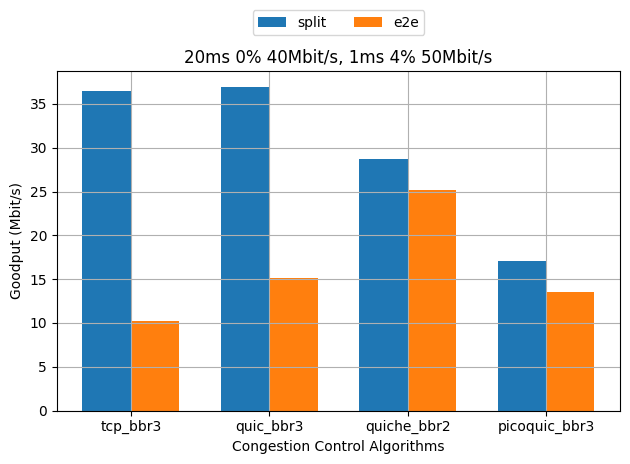

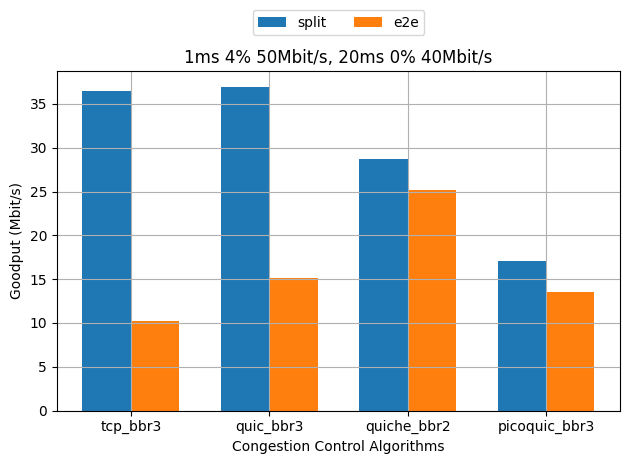

...


In [21]:
# Partition data
data = {treatment.label(): TreatmentData(treatment, direct_data) for treatment in treatments[4:]}

# Get initial results
results = get_initial_results(data, network_settings)

# Filter by required result trend criteria
results = filter_by(results, lambda x: True)
results = filter_by(results, lambda x: x.e2e_ratio(TCP_BBRV3) < 0.5, 'tcp split improvement is significant')
results = filter_by(results, lambda x: x.split_ratio(TCP_BBRV3) > 0.8, 'tcp split improvement is significant')
results = filter_by(results, lambda x: x.split_improvement_mul(TCP_BBRV3) > 1, 'tcp split improvement is significant')
results = filter_by(results, lambda x: x.e2e_ratio(QUIC_BBRV3) < 0.5, 'chromium split improvement is significant')
results = filter_by(results, lambda x: x.split_ratio(QUIC_BBRV3) > 0.8, 'chromium split improvement is significant')
results = filter_by(results, lambda x: x.split_improvement_mul(QUIC_BBRV3) > 1, 'chromium split improvement is significant')

# results = filter_by(results, lambda x: 0 < x.split_ratio(QUICHE_CUBIC), 'quiche split performance is nonzero')
# results = filter_by(results, lambda x: x.split_improvement_mul(QUICHE_CUBIC) > 1, 'quiche large split improvement')
# results = filter_by(results, lambda x: x.split_improvement_mul(PICOQUIC_CUBIC) > 1, 'picoquic large split improvement')

# results = filter_by(results, lambda x: x.e2e_ratio(TCP_CUBIC) < 0.2, 'small e2e ratio')
# results = filter_by(results, lambda x: x.e2e_ratio(QUIC_CUBIC) < 0.2, 'small e2e ratio')
# results = filter_by(results, lambda x: x.e2e_ratio(QUICHE_CUBIC) < 0.2, 'small e2e ratio')
# results = filter_by(results, lambda x: x.e2e_ratio(PICOQUIC_CUBIC) < 0.2, 'small e2e ratio')
# results = filter_by(results, lambda x: x.split_ratio(TCP_CUBIC) < 0.2, 'small split ratio')
# results = filter_by(results, lambda x: x.split_ratio(QUIC_CUBIC) < 0.2, 'small split ratio')
# results = filter_by(results, lambda x: x.split_ratio(QUICHE_CUBIC) > 0.85, 'large split ratio')
# results = filter_by(results, lambda x: x.split_ratio(PICOQUIC_CUBIC) > 0.85, 'large split ratio')

# Show results
show_random_results(results)